# Manual Knowledge Graph Construction for Educational Content Recommendation

This notebook demonstrates the construction of a knowledge graph for educational videos from [DigitalSreeni's YouTube channel](https://www.youtube.com/watch?v=LSuNRtw5f3A&list=PLZsOBAyNTZwacEFVI8yo5o-1rZasRqm18&index=3) using a manual, expert-driven approach. Unlike automated methods, this technique involves explicitly defining:

* Nodes (topics)
* Edges (relationships between topics)
* Edge weights (representing the strength or relevance of those relationships)

This approach relies on domain expertise to ensure accurate and meaningful learning paths.

## Domains Covered

The example focuses on three main educational domains:

* Core Python programming concepts
* Financial analysis and algorithmic trading
* Bioimage analysis and microscopy

## Topic Metadata

Each topic in the graph is manually annotated with the following metadata:

* **Difficulty level**: beginner, intermediate, or advanced
* **Keywords**: to support filtering and content identification
* **Domain classification**: to group topics within their relevant field
* **Description**: a concise explanation of the topic

## Edge Weights and Relationships

Edges between topics are assigned weights ranging from 0.0 to 1.0, indicating:

* **Prerequisite strength**: how essential one topic is for understanding another
* **Content similarity**: the degree of overlap between topics
* **Learning progression**: the recommended order in which topics should be studied

## Visualization and Data Storage

To support both learning and analysis:

* The graph is **visualized interactively** using Pyvis
* A **static version** is rendered using Matplotlib
* All graph data is **stored in a SQLite database** for persistence and querying

## Limitations and Considerations

While the manual approach provides precise, expert-curated learning paths, it is labor-intensive and less scalable for large or frequently updated content libraries. In such cases, an AI-assisted or automated method in the next material [09_Building_KG_with_LLM_Embeddings](./09_Building_KG_with_LLM_Embeddings.ipynb) may offer better scalability by automatically discovering relationships and adapting to new content.

In [1]:
# Imports

import networkx as nx
from pyvis.network import Network
from typing import Dict, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt

### **Step 1: Define Topic Dictionaries**

In this step, we define domain-specific topic dictionaries that serve as the foundational nodes for our knowledge graph. Each topic is manually annotated with important metadata such as difficulty level, relevant keywords, domain, and a short description.

The `create_topic_dictionaries()` function returns three dictionaries — one for each content domain (`programming`, `finance`, and `bioimage analysis`). These dictionaries will later be used to build the nodes and edges of the knowledge graph.


In [2]:
def create_topic_dictionaries():
    """Create dictionaries containing topic information for different domains"""
    # Core Python topics
    python_topics = {
        'python_basics': {
            'difficulty': 'beginner',
            'keywords': ['programming', 'syntax', 'basics'],
            'domain': 'programming',
            'description': 'Basic Python programming concepts'
        },
        'data_types_variables': {
            'difficulty': 'beginner',
            'keywords': ['variables', 'types', 'basics'],
            'domain': 'programming',
            'description': 'Python data types and variables'
        },
        'control_flow': {
            'difficulty': 'beginner',
            'keywords': ['loops', 'conditionals', 'basics'],
            'domain': 'programming',
            'description': 'Control flow in Python'
        },
        'functions_basics': {
            'difficulty': 'beginner',
            'keywords': ['functions', 'methods', 'basics'],
            'domain': 'programming',
            'description': 'Python functions fundamentals'
        },
        'data_structures': {
            'difficulty': 'intermediate',
            'keywords': ['lists', 'dictionaries', 'arrays'],
            'domain': 'programming',
            'description': 'Python data structures'
        },
        'file_handling': {
            'difficulty': 'intermediate',
            'keywords': ['files', 'io', 'data'],
            'domain': 'programming',
            'description': 'File handling in Python'
        },
        'error_handling': {
            'difficulty': 'intermediate',
            'keywords': ['exceptions', 'errors', 'debugging'],
            'domain': 'programming',
            'description': 'Error handling and debugging'
        },
        'oop_basics': {
            'difficulty': 'intermediate',
            'keywords': ['classes', 'objects'],
            'domain': 'programming',
            'description': 'Object-oriented programming basics'
        },
        'advanced_oop': {
            'difficulty': 'advanced',
            'keywords': ['inheritance', 'polymorphism'],
            'domain': 'programming',
            'description': 'Advanced OOP concepts'
        }
    }

    # Finance path topics
    finance_topics = {
        'economics_101': {
            'difficulty': 'beginner',
            'keywords': ['economics', 'markets', 'basics'],
            'domain': 'finance',
            'description': 'Basic economic concepts'
        },
        'stock_market_basics': {
            'difficulty': 'beginner',
            'keywords': ['stocks', 'trading', 'markets'],
            'domain': 'finance',
            'description': 'Stock market fundamentals'
        },
        'financial_statements': {
            'difficulty': 'intermediate',
            'keywords': ['accounting', 'finance', 'analysis'],
            'domain': 'finance',
            'description': 'Understanding financial statements'
        },
        'technical_analysis': {
            'difficulty': 'intermediate',
            'keywords': ['charts', 'patterns', 'indicators'],
            'domain': 'finance',
            'description': 'Technical analysis basics'
        },
        'financial_analysis_basics': {
            'difficulty': 'intermediate',
            'keywords': ['analysis', 'metrics', 'finance'],
            'domain': 'finance',
            'description': 'Basic financial analysis'
        },
        'python_finance': {
            'difficulty': 'intermediate',
            'keywords': ['python', 'finance', 'analysis'],
            'domain': 'finance',
            'description': 'Python for financial analysis'
        },
        'algorithmic_trading': {
            'difficulty': 'advanced',
            'keywords': ['algorithms', 'trading', 'finance'],
            'domain': 'finance',
            'description': 'Algorithmic trading with Python'
        }
    }

    # Bioimage analysis path topics
    bioimage_topics = {
        'cell_biology_basics': {
            'difficulty': 'beginner',
            'keywords': ['biology', 'cells', 'basics'],
            'domain': 'biology',
            'description': 'Basic cell biology'
        },
        'microscopy_basics': {
            'difficulty': 'beginner',
            'keywords': ['microscopy', 'imaging', 'basics'],
            'domain': 'biology',
            'description': 'Basic microscopy concepts'
        },
        'image_formats': {
            'difficulty': 'beginner',
            'keywords': ['images', 'formats', 'data'],
            'domain': 'biology',
            'description': 'Understanding image formats and metadata'
        },
        'image_analysis_basics': {
            'difficulty': 'intermediate',
            'keywords': ['image analysis', 'processing'],
            'domain': 'biology',
            'description': 'Basic image analysis'
        },
        'image_processing': {
            'difficulty': 'intermediate',
            'keywords': ['processing', 'filters', 'analysis'],
            'domain': 'biology',
            'description': 'Image processing techniques'
        },
        'python_imaging': {
            'difficulty': 'intermediate',
            'keywords': ['python', 'imaging', 'analysis'],
            'domain': 'biology',
            'description': 'Python for image analysis'
        },
        'advanced_bioimage': {
            'difficulty': 'advanced',
            'keywords': ['bioimage', 'advanced', 'analysis'],
            'domain': 'biology',
            'description': 'Advanced bioimage analysis'
        }
    }

    return python_topics, finance_topics, bioimage_topics

### **Step 2: Define Relationships Between Topics**

Next, we define the relationships (edges) between topics. Each relationship is represented as a tuple:

```python
(source_topic, target_topic, weight)


In [3]:

def define_relationships():
    """Define relationships between topics with weights"""
    return [
        # Python core path
        ('python_basics', 'data_types_variables', 1.0),
        ('data_types_variables', 'control_flow', 1.0),
        ('control_flow', 'functions_basics', 1.0),
        ('functions_basics', 'data_structures', 0.9),
        ('data_structures', 'file_handling', 0.8),
        ('data_structures', 'error_handling', 0.8),
        ('data_structures', 'oop_basics', 0.8),
        ('oop_basics', 'advanced_oop', 0.7),

        # Finance path
        ('economics_101', 'stock_market_basics', 1.0),
        ('stock_market_basics', 'financial_statements', 0.9),
        ('financial_statements', 'financial_analysis_basics', 0.9),
        ('stock_market_basics', 'technical_analysis', 0.8),
        ('python_basics', 'python_finance', 0.7),
        ('financial_analysis_basics', 'python_finance', 0.8),
        ('data_structures', 'python_finance', 0.7),
        ('technical_analysis', 'python_finance', 0.7),
        ('python_finance', 'algorithmic_trading', 0.6),

        # Bioimage path
        ('cell_biology_basics', 'microscopy_basics', 1.0),
        ('microscopy_basics', 'image_formats', 0.9),
        ('image_formats', 'image_analysis_basics', 0.9),
        ('image_analysis_basics', 'image_processing', 0.8),
        ('python_basics', 'python_imaging', 0.7),
        ('image_processing', 'python_imaging', 0.8),
        ('data_structures', 'python_imaging', 0.7),
        ('python_imaging', 'advanced_bioimage', 0.6)
    ]

### **Step 3: Build the Knowledge Graph**

Now that we have defined the topics (nodes) and their relationships (edges), we build the actual knowledge graph using NetworkX.

The `build_graph()` function performs the following steps:

1. Retrieves topic dictionaries for all domains
2. Combines them into a single topic dictionary
3. Adds each topic to a **directed graph (DiGraph)**, attaching its metadata as node attributes
4. Adds relationships (edges) between topics, each with a weight and a relationship type

This function returns both:
- The complete graph (`graph`)
- A dictionary of all topic metadata (`topic_metadata`)


In [4]:
def build_graph():
    """Build the knowledge graph with topics and relationships"""
    graph = nx.DiGraph()

    #Get the dictionaries for the topics we defined earlier
    python_topics, finance_topics, bioimage_topics = create_topic_dictionaries()

    # Combine all topics and unwrap topic and metadata
    all_topics = {**python_topics, **finance_topics, **bioimage_topics}

    # Add nodes for topic_id and assign metadata key-value pairs as attributes of the node.
    for topic_id, metadata in all_topics.items():
        graph.add_node(topic_id, **metadata)

    # Add relationships (edges)
    relationships = define_relationships()
    for from_topic, to_topic, weight in relationships:
        graph.add_edge(from_topic, to_topic, weight=weight, type='prerequisite')

    return graph, all_topics

# Build the graph
graph, topic_metadata = build_graph()

### **Step 4: Visualize the Knowledge Graph**

To gain insights into the structure and learning pathways within the knowledge graph, we provide two visualization methods: one **interactive** (browser-based) and one **static** (image-based).

#### Interactive Visualization with Pyvis

The function `visualize_graph_pyvis()` uses **Pyvis** to generate an interactive, browser-based visualization. It renders:

* **Nodes**, color-coded by domain (programming, finance, biology)
* **Edges**, representing prerequisite or similarity relationships, with hoverable weight values
* **Tooltips**, displaying topic difficulty, domain, and description

This method enables dynamic exploration of the graph. The output is saved as an HTML file (`learning_paths.html` by default), which can be opened in any web browser.

#### Static Visualization with Matplotlib

If interactive rendering is not available or practical, the `visualize_graph_matplotlib()` function uses **Matplotlib** and **NetworkX** to display a static version of the graph. It includes:

* Node coloring by domain
* Labeled nodes and directional edges
* A spring layout for visual clarity

This is a suitable fallback or alternative in environments that do not support HTML-based rendering.

In [5]:
def visualize_graph_pyvis(graph: nx.DiGraph, topic_metadata: Dict, output_file='learning_paths.html'):
    """Create interactive visualization using Pyvis"""
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", directed=True)

    # Color map for different domains
    color_map = {
        'programming': '#add8e6',  # light blue
        'finance': '#90EE90',      # light green
        'biology': '#FA8072'       # salmon
    }

    # Add nodes
    for node in graph.nodes():
        metadata = graph.nodes[node]
        net.add_node(
            node,
            label=node.replace('_', ' ').title(),
            title=f"Domain: {metadata['domain']}\n"
                  f"Difficulty: {metadata['difficulty']}\n"
                  f"Description: {metadata['description']}",
            color=color_map[metadata['domain']]
        )

    # Add edges
    for edge in graph.edges(data=True):
        net.add_edge(edge[0], edge[1], title=f"Weight: {edge[2]['weight']}")

    try:
        # This line actually generates and saves the visualization as an HTML file.
        # The filename comes from the 'output_file' parameter, which defaults to "learning_paths.html".
        net.show(output_file)

        print(f"Graph visualization saved to {output_file}")
    except Exception as e:
        print(f"Error in visualization: {e}")
        visualize_graph_matplotlib(graph)

def visualize_graph_matplotlib(graph: nx.DiGraph):
    """Create static visualization using matplotlib"""
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(graph, k=1, iterations=50)

    # Color nodes based on domain
    colors = []
    for node in graph.nodes():
        domain = graph.nodes[node]['domain']
        if domain == 'programming':
            colors.append('lightblue')
        elif domain == 'finance':
            colors.append('lightgreen')
        else:
            colors.append('salmon')

    nx.draw(graph, pos,
            node_color=colors,
            with_labels=True,
            node_size=2000,
            font_size=8,
            font_weight='bold',
            arrows=True,
            edge_color='gray',
            arrowsize=20)

    plt.title("Learning Paths Graph")
    plt.show()


In [6]:
# Create pyvis visualizations -> learning_paths.html
visualize_graph_pyvis(graph, topic_metadata)

learning_paths.html
Graph visualization saved to learning_paths.html


**You can use any browser to open the `learning_paths.html` which is saved in your current directory**

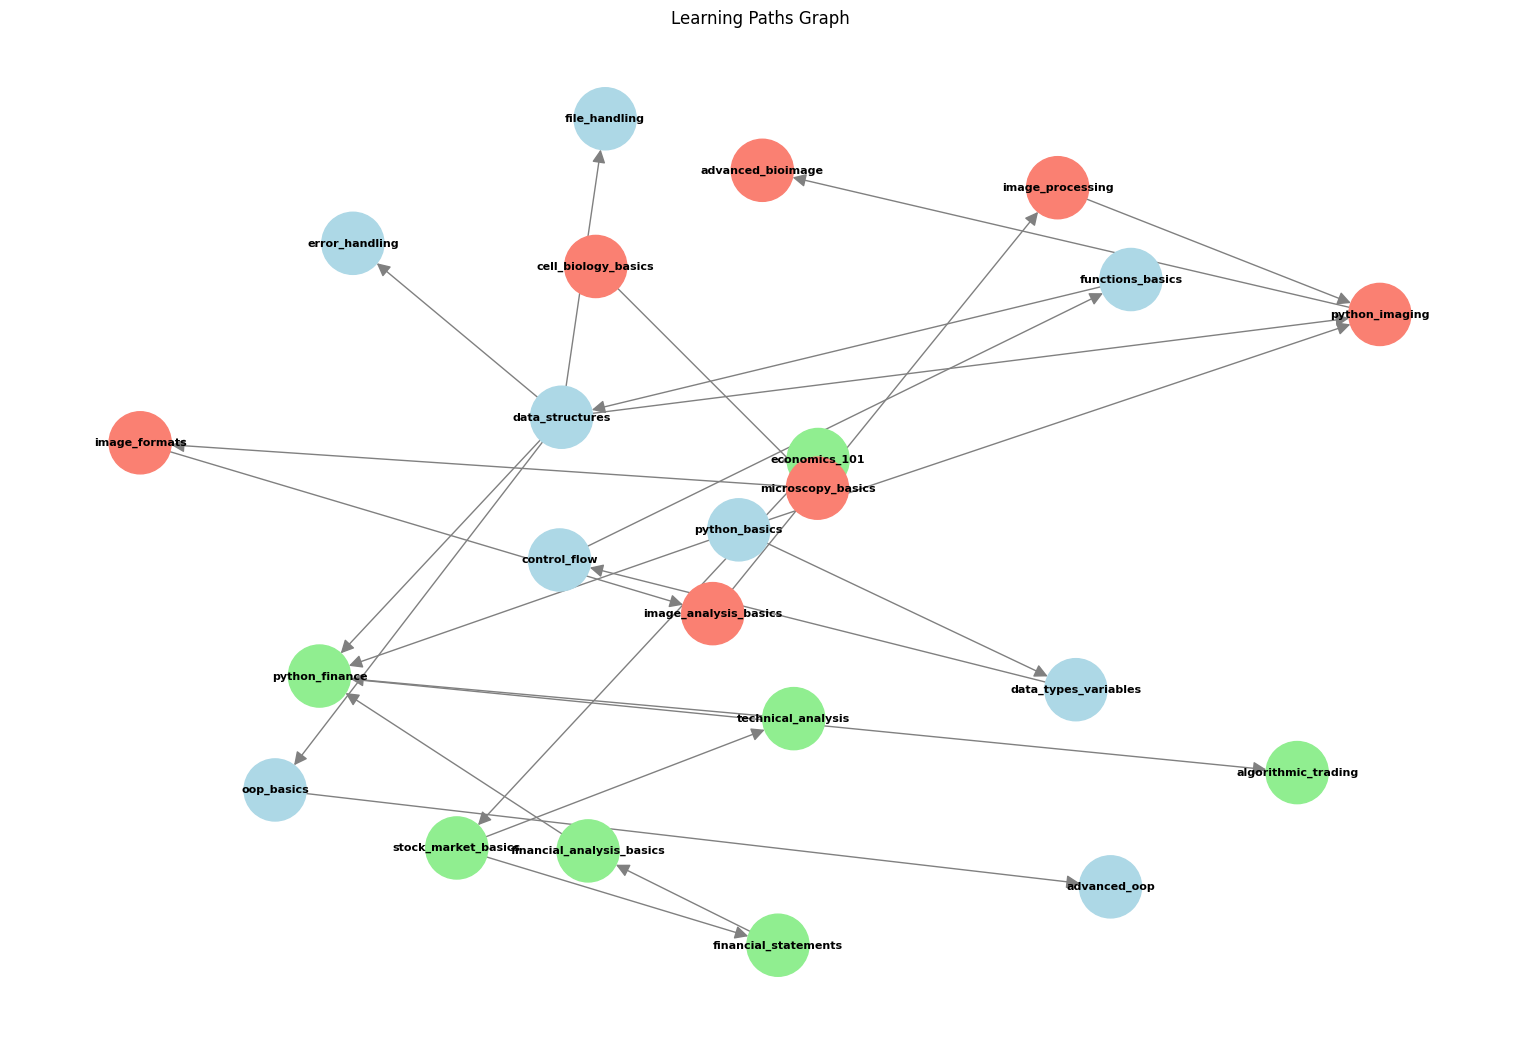

In [7]:
# Create matplotlib visualizations
visualize_graph_matplotlib(graph)

### **Step 5: Analyze the Knowledge Graph**

With the graph constructed and visualized, we can now perform basic **graph analytics** to extract insights.

The `basic_analysis()` function computes:

- **PageRank**: Identifies the most important topics in the graph based on how many other topics lead to them. This is useful for highlighting core concepts.
- **In-degree centrality**: Measures how many incoming edges a node has, showing which topics are most often treated as prerequisites.
- **Betweenness centrality**: Identifies "bridge" topics that connect different parts of the graph. These are often interdisciplinary or transitional topics.

These metrics help us understand how learning paths are structured and which topics may deserve special attention.


In [8]:
def basic_analysis(graph: nx.DiGraph):
    """Run basic analysis on the graph and display results."""
    # Calculate and display PageRank
    pagerank = nx.pagerank(graph)
    print("\nPageRank of nodes (indicating topic importance):")

    # Sort dictionary items (pagerank.items()) by their value in descending order
    for node, rank in sorted(pagerank.items(), key=lambda x: x[1], reverse=True):
        print(f"{node}: {rank:.4f}")

    # Calculate degree centrality
    in_degree = nx.in_degree_centrality(graph)
    print("\nIn-degree centrality (topics that are important prerequisites):")
    for node, centrality in sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(graph)
    print("\nBetweenness centrality (bridge topics between domains):")
    for node, centrality in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

In [9]:
# Run basic analysis
print("Running basic graph analysis...")
basic_analysis(graph)

Running basic graph analysis...

PageRank of nodes (indicating topic importance):
algorithmic_trading: 0.0930
python_finance: 0.0899
advanced_bioimage: 0.0860
python_imaging: 0.0817
image_processing: 0.0614
data_structures: 0.0563
image_analysis_basics: 0.0527
functions_basics: 0.0468
image_formats: 0.0426
financial_analysis_basics: 0.0423
advanced_oop: 0.0392
control_flow: 0.0356
stock_market_basics: 0.0306
microscopy_basics: 0.0306
financial_statements: 0.0303
technical_analysis: 0.0288
file_handling: 0.0266
error_handling: 0.0266
oop_basics: 0.0266
data_types_variables: 0.0224
python_basics: 0.0166
economics_101: 0.0166
cell_biology_basics: 0.0166

In-degree centrality (topics that are important prerequisites):
python_finance: 0.1818
python_imaging: 0.1364
data_types_variables: 0.0455
control_flow: 0.0455
functions_basics: 0.0455

Betweenness centrality (bridge topics between domains):
data_structures: 0.0606
functions_basics: 0.0498
control_flow: 0.0346
python_finance: 0.0216
pytho

### **Step 6: Query the Graph for Prerequisites**

In a real educational setting, one key question learners might ask is:  
**"What do I need to know before learning a specific topic?"**

To support this, we implement a query function that retrieves all **prerequisite topics** (i.e., predecessors in the graph) for a given target topic, up to a specified depth.

- `get_prerequisites()` traverses the graph in reverse from a given topic and groups prerequisites by how many steps away they are.
- `print_prerequisites_analysis()` formats and prints the results, including topic difficulty and description.

This kind of querying is foundational for building **personalized learning paths**.


In [10]:
def get_prerequisites(graph: nx.DiGraph, topic: str, max_depth=3):
    """
    Find prerequisites for a given topic up to a specified depth.

    Args:
        graph: NetworkX directed graph
        topic: Target topic to find prerequisites for
        max_depth: Maximum depth to search for prerequisites

    Returns:
        Dict of prerequisites with their minimum distance from the target topic
    """
    if topic not in graph.nodes():
        print(f"Error: Topic '{topic}' not found in the graph")
        return {}

    prerequisites = {}
    current_depth = 1
    current_nodes = {topic}
    visited = set()

    # while current_depth <=  max depth and current_nodes is not empty
    while current_depth <= max_depth and current_nodes:
        next_nodes = set()
        for node in current_nodes:
            # Get immediate predecessors (prerequisites)
            for pred in graph.predecessors(node):
                if pred not in visited and pred not in prerequisites:
                    prerequisites[pred] = current_depth

                    # Add the new node "pred" to the next_nodes set
                    next_nodes.add(pred)
            visited.add(node)
        current_nodes = next_nodes
        current_depth += 1

    return prerequisites

def print_prerequisites_analysis(graph: nx.DiGraph, topic: str):
    """Print prerequisite analysis for a given topic"""
    print(f"\nPrerequisite Analysis for: {topic}")
    print("-" * 50)

    prereqs = get_prerequisites(graph, topic)
    if not prereqs:
        return

    # Group prerequisites by depth
    depth_groups = defaultdict(list)  # if a key does not exit this "defaultdict" will auto-create a key mapped to an empty list

 
    for topic, depth in prereqs.items():
    # Reverse mapping: prereqs maps topic→depth, but for printing
    # we want depth→[topics] so we can easily group by learning level
        depth_groups[depth].append(topic)

    # Print prerequisites by level
    for depth in sorted(depth_groups.keys()):
        print(f"\nLevel {depth} prerequisites:")
        for prereq in depth_groups[depth]:
            metadata = graph.nodes[prereq]
            print(f"- {prereq.replace('_', ' ').title()}:")
            print(f"  Difficulty: {metadata['difficulty']}")
            print(f"  Description: {metadata['description']}")

In [11]:
# Example prerequisite analysis
print("\nAnalyzing prerequisites...")
print_prerequisites_analysis(graph, 'algorithmic_trading')


Analyzing prerequisites...

Prerequisite Analysis for: algorithmic_trading
--------------------------------------------------

Level 1 prerequisites:
- Python Finance:
  Difficulty: intermediate
  Description: Python for financial analysis

Level 2 prerequisites:
- Python Basics:
  Difficulty: beginner
  Description: Basic Python programming concepts
- Financial Analysis Basics:
  Difficulty: intermediate
  Description: Basic financial analysis
- Data Structures:
  Difficulty: intermediate
  Description: Python data structures
- Technical Analysis:
  Difficulty: intermediate
  Description: Technical analysis basics

Level 3 prerequisites:
- Financial Statements:
  Difficulty: intermediate
  Description: Understanding financial statements
- Stock Market Basics:
  Difficulty: beginner
  Description: Stock market fundamentals
- Functions Basics:
  Difficulty: beginner
  Description: Python functions fundamentals


### **Step 7: Personalized Learning Path Recommendation**

In this step, we'll implement a function to recommend a learning sequence tailored to a user's domain of interest:

- The starting point is always `python_basics`.
- The endpoint is an **advanced goal** in the chosen domain:
  - `'algorithmic_trading'` for **finance**
  - `'advanced_bioimage'` for **bioimage analysis**
- We use **shortest paths** to find the most efficient learning route.
- The function also surfaces **supplementary topics** in the same domain that might enhance the learning journey.

This enables intelligent curriculum design and adaptive tutoring based on user intent.


In [ ]:
def recommend_learning_path(graph: nx.DiGraph, domain: str):
    """
    Recommend a learning path for a specific domain (finance or bioimage).

    Args:
        graph: NetworkX directed graph
        domain: Target domain ('finance' or 'bioimage')
    """
    if domain not in ['finance', 'bioimage']:
        print("Error: Domain must be either 'finance' or 'bioimage'")
        return

    print(f"\nRecommended Learning Path for Python in {domain.title()}")
    print("-" * 50)

    # Define target nodes based on domain
    if domain == 'finance':
        target_node = 'algorithmic_trading'
        domain_identifier = 'finance'
    else:
        target_node = 'advanced_bioimage'
        domain_identifier = 'biology'

    # Find all shortest paths from python_basics to target node
    try:
        paths = nx.all_shortest_paths(graph, 'python_basics', target_node, weight='weight')
        paths = list(paths)  # Convert generator to list
    except nx.NetworkXNoPath:
        print(f"No path found from Python basics to advanced {domain} topics")
        return

    # Get the optimal path (you might want to consider weights or other factors)
    optimal_path = paths[0]  # Taking the first shortest path: This path is list of topics

    print("Recommended learning sequence:")
    for i, topic in enumerate(optimal_path, 1): # Loop through optimal_path with index starting at 1: This will be use to compare current and next topic
        metadata = graph.nodes[topic]
        print(f"\n{i}. {topic.replace('_', ' ').title()}:")
        print(f"   Difficulty: {metadata['difficulty']}")
        print(f"   Description: {metadata['description']}")

        if i < len(optimal_path):
            # Fetch the edge (connection) data between the current topic (topic) and the next topic (optimal_path[i])
            edge_data = graph.get_edge_data(topic, optimal_path[i])

            # Check if the edge exists and has a 'weight' attribute
            if edge_data and 'weight' in edge_data:
                # Calculate and print transition difficulty as a percentage
                print(f"   Transition Difficulty: {(1 - edge_data['weight']) * 100:.1f}%")

    # Select only nodes that:
    # 1. Belong to the same domain (finance or bioimage) as the chosen path
    # 2. Are NOT already part of the optimal learning path
    # 3. Are not advanced-level topics (to keep supplementary material approachable)
    print("\nSupplementary topics you might find useful:")
    for node, metadata in graph.nodes(data=True):
        if (metadata['domain'] == domain_identifier and
            node not in optimal_path and
            metadata['difficulty'] != 'advanced'):
            print(f"- {node.replace('_', ' ').title()} ({metadata['difficulty']})")


In [15]:
# Example learning path recommendations
print("\nGenerating learning path recommendations...")
recommend_learning_path(graph, 'finance')
recommend_learning_path(graph, 'bioimage')


Generating learning path recommendations...

Recommended Learning Path for Python in Finance
--------------------------------------------------
Recommended learning sequence:

1. Python Basics:
   Difficulty: beginner
   Description: Basic Python programming concepts
   Transition Difficulty: 30.0%

2. Python Finance:
   Difficulty: intermediate
   Description: Python for financial analysis
   Transition Difficulty: 40.0%

3. Algorithmic Trading:
   Difficulty: advanced
   Description: Algorithmic trading with Python
- Economics 101 (beginner)
- Stock Market Basics (beginner)
- Financial Statements (intermediate)
- Technical Analysis (intermediate)
- Financial Analysis Basics (intermediate)

Recommended Learning Path for Python in Bioimage
--------------------------------------------------
Recommended learning sequence:

1. Python Basics:
   Difficulty: beginner
   Description: Basic Python programming concepts
   Transition Difficulty: 30.0%

2. Python Imaging:
   Difficulty: interme

### **Complete KG playlist:**
[**DigitalSreeni YouTube Playlist**](https://youtube.com/playlist?list=PLZsOBAyNTZwacEFVI8yo5o-1rZasRqm18&si=l_6g-_QmIud5h1Kk) – for providing an excellent set of biomedical imaging tutorials that were used in the recommender system example.
